2021-04-09 22:28:19,428 -<ipython-input-62-0576e2c7ce39>-<ipython-input-62-0576e2c7ce39>[line:43] - WARNING: get symbol ohlcv: SAND/USDT
2021-04-09 22:28:19,660 -category-category.py[line:218] - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2021-04-09 22:28:19,681 -category-category.py[line:218] - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


[('0814 08', None), ('0815 08', None), ('0816 08', None), ('0817 08', None), ('0818 08', None), ('0819 08', None), ('0820 08', 0.055545), ('0821 08', 0.052439), ('0822 08', 0.051706), ('0823 08', 0.049243), ('0824 08', 0.048804), ('0825 08', 0.048285), ('0826 08', 0.049232), ('0827 08', 0.052156), ('0828 08', 0.055832), ('0829 08', 0.059659), ('0830 08', 0.062951), ('0831 08', 0.065704), ('0901 08', 0.067389), ('0902 08', 0.06735), ('0903 08', 0.063026), ('0904 08', 0.059439), ('0905 08', 0.054405), ('0906 08', 0.050733), ('0907 08', 0.046297), ('0908 08', 0.04484), ('0909 08', 0.043399), ('0910 08', 0.044228), ('0911 08', 0.045177), ('0912 08', 0.046868), ('0913 08', 0.047236), ('0914 08', 0.048292), ('0915 08', 0.047235), ('0916 08', 0.046658), ('0917 08', 0.045859), ('0918 08', 0.04478), ('0919 08', 0.044457), ('0920 08', 0.044378), ('0921 08', 0.043242), ('0922 08', 0.04348), ('0923 08', 0.043274), ('0924 08', 0.043836), ('0925 08', 0.04447), ('0926 08', 0.044389), ('0927 08', 0.04

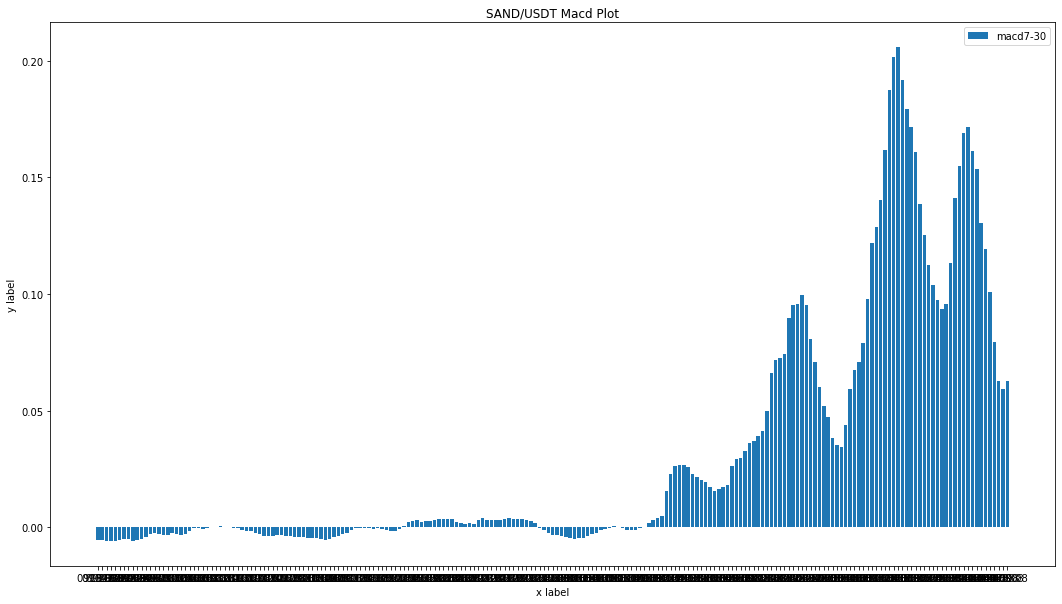

In [62]:
from copy import deepcopy
import logging
import time
import ccxt
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt

from base import BaseExchange
from conf import dev_symbols
from conf import all_symbols

logging.basicConfig(format='%(asctime)s -%(module)s-%(filename)s[line:%(lineno)d] - %(levelname)s: %(message)s',
                    level=logging.INFO)
pd.set_option('precision', 10)

class Binance(BaseExchange):
    """
    """
    def __init__(self):
        super().__init__()
        self.name = 'Binance'
        self.logger = logging.getLogger(f'{__name__}.{self.name}')
        
        self.api = ccxt.binance()
        
        self.api.enableRateLimit = True
        self.api.rateLimit = 200
        self.symbol_list = deepcopy(super().k15_symbol_list)
        self.symbol_list.append('BNB/USDT')
        dict_market = self.api.load_markets()
        # self.symbols = dev_symbols
        # self.symbol_filter_hook(dict_market)
        # self.price_dict = self.quote_price_exchange(dict_market)
    
    def quote_price_exchange(self, dict_market):
        pass
        
    def get_ohlcv(self, symbol):
        if symbol in self.api.markets:
            time.sleep(self.api.rateLimit/1000)
            self.logger.warning(f"get symbol ohlcv: {symbol}")
            # fetchOHLCV (symbol, timeframe = '1m', since = undefined, limit = undefined, params = {})
            # result array is order by microsec ascending
            # [[ms, open, high, low, close, vol],[]]
            return self.api.fetch_ohlcv(symbol, '1d', limit=1000)
        return None
        
def calc_sma(candles, wsize):
    """
    @param candles: list of kline data, element (ts, value)
    @param msize: window size
    """
    if wsize > len(candles):
        print(f'len(candels) less than {wsize}, return None')
        return None
    first = (candles[wsize-1][0], sum([c[1] for c in candles[:wsize]])/wsize)
    result = []
    # for 10, 4, range result is 4 to 9
    # Todo: for i < wsize, result should be None
    # for i in range(wsize, len(candles)):
    for i in range(0, len(candles)):
        # 1: 0:4 wsize=4
        # 2: 1:5 
        # 3: 2:6
        # 边界情况：sma[wsize-1] = 前wsize个数的平均值
        if i < wsize-1:
            result.append(( candles[i][0], None) )
            continue
        item = (candles[i][0]) , round( sum([c[1] for c in candles[i+1-wsize:i+1]])/wsize,6)
        result.append(item)
    return result
    

def calc_ema(smas, values, wsize, smoothing=2):
    """
    @param smas:
    @param values:
    @param wsize: window size
    @smoothin: factor that decide the weight of recent value
    @return ema_result: dict
    """
    # exponential moving average 
    # EMA(Today)=(ValueToday ∗ Smoothing/(1+WindowSize)) + EMAYesterday∗ (1− Smoothing/(1+WindowSize))
    # EMA = Closing price x multiplier + EMA (previous day) x (1-multiplier)
    # The result length will have len(values) - wsize
    # ex. 30 days data for values array, compute 20day-ema, there will be only 10 result
    result_size = len(values) - wsize
    ema_result = {}
    # the first to be calc is index 20, mean 21th data
    # item element is (ts, val)
    # for item in values[wsize:]:
    # Bugs: smas数组的大小比预期的大1
    # print(smas)
    # print(values)
    # print(len(values) + 1)
    ema_last = smas[wsize-1][1]
    print(f'最初的EMA {smas[wsize-1][0]} {smas[wsize-1][1]}')
    for i in range(wsize, len(values)):
        key=values[i][0]
        print(f"{key} 最新价格:{values[i][1]} 上一个ema:{ema_last}")
        ema = round( values[i][1] * smoothing/(1+wsize) + ema_last * (1-smoothing/(1+wsize)), 6)
        ema_result[key] = ema
        # 更新上一次EMA
        ema_last = ema
    return ema_result

def calc_macd(es1, es2):
    # MACD=7-Period EMA − 30-Period EMA
    result={}
    for item in es2:
        # Todo: 判断es2里面如果不存在
        result[item] = es1[item] - es2[item]
        print(f"{item} ema1:{es1[item]} ema2:{es2[item]} diff:{result[item]}")
    return result

def draw_histogram(x, y, symbol):
    fig, ax = plt.subplots()
    ax.bar(x, y, label='macd7-30')
    
    # plt.ylim([-2000, 2000])
    ax.set_xlabel('x label')
    ax.set_ylabel('y label')
    ax.set_title(f'{symbol} Macd Plot')
    ax.legend()
    fig.set_size_inches(18, 10)
    plt.show()

        
if __name__ == '__main__':
#     binance = Binance()
#     ohlcvs = binance.get_ohlcv('BTC/USDT')
#     closes = [(i[0],i[4]) for i in ohlcvs]
#     smas7 = calc_sma(closes, 7)
#     ema7 = calc_ema(smas7, closes, 7)
# #     print(ema7)
#     smas30 = calc_sma(closes, 30)
#     ema30 = calc_ema(smas30, closes, 30)
# #     print(ema30)
#     macd_his=calc_macd(ema7, ema30)
# #     print(macd_his)
#     x_series = [datetime.fromtimestamp(i/1000).strftime('%Y%m%d %H:%M:%S') for i in macd_his.keys()]
#     print(x_series)
#     draw_histogram(x_series, macd_his.values(), 'BTC')
    
    binance = Binance()
    for symbol in all_symbols:
        ohlcvs = binance.get_ohlcv(symbol)
        closes = [(datetime.fromtimestamp(i[0]/1000).strftime('%m%d %H'),i[4]) for i in ohlcvs]
        smas7 = calc_sma(closes, 7)
        print(smas7)
        ema7 = calc_ema(smas7, closes, 7)
#         print(ema7)
        smas30 = calc_sma(closes, 30)
        print(smas7)
#         print(smas30)
        ema30 = calc_ema(smas30, closes, 30)
        macd_his=calc_macd(ema7, ema30)
        # x_series = [datetime.fromtimestamp(i/1000).strftime('%m%d %H') for i in macd_his.keys()]
        draw_histogram(macd_his.keys(), macd_his.values(), symbol)
        
    
#     print(sma_calc(closes, 7))
#     print(sma_calc(closes, 30))

In [ ]:
import time

import ccxt

from conf import dev_symbols

api = ccxt.binance()
api.load_markets()
# api.markets['BTC/USDT']


        

In [6]:
api.rateLimit

NameError: name 'api' is not defined

In [7]:
all_symbols

{'BNB/USDT', 'BTC/USDT', 'ETH/USDT'}